Linear Regression Recipe
=================
Take some data that includes a response variable (y) and one or more predictors (x1, x2).
We assume that the first column is the response variable.

| y    |  x1 |  x2 |
|------|----:|----:|
| 1.4  |  2  |  2  |
| 2.4  | 3.1 | 4.1 |
| 3.34 | 4.4 | 1.3 |
 
We apply linear regression several different ways.

In [1]:
from __future__ import print_function, division
import requests

import numpy as np
import seaborn as sns
import pandas as pd
import pymc3 as pm
import matplotlib as mpl
import matplotlib.pyplot as plt

from StringIO import StringIO
from pprint import pprint
from IPython.display import display, HTML, SVG
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm, probplot

def uprint(astr): print(astr + "\n" + "-"*len(astr))
def show_html(astr): return display(HTML('<center>{}</center>'.format(astr)))

def show_svg(astr, w=1000, h=1000): 
    SVG_HEAD = '''<?xml version="1.0" standalone="no"?><!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" "http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">'''
    SVG_START = '''<svg width="{w:}px" height="{h:}px" version="1.1" xmlns="http://www.w3.org/2000/svg" xmlns:xlink= "http://www.w3.org/1999/xlink">'''
    return display(SVG(SVG_HEAD + SVG_START.format(w=w, h=h) + astr + '</svg>'))

# Plotting style
plt.rc("axes", titlesize=20, labelsize=15, linewidth=.25, edgecolor='#444444')
sns.set_context("notebook", font_scale=1.2, rc={})
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Data
====
Here we load the data into a DataFrame and look at a summary.

In [2]:
# Read in data from google spreadsheet
gsheet_key = "1q2xrN2YQ4KrGedaupDX2aM9dWGSmz23v7UF2GxwlO0A"
gsheet_url = "https://docs.google.com/spreadsheets/d/1q2xrN2YQ4KrGedaupDX2aM9dWGSmz23v7UF2GxwlO0A/edit?usp=sharing"

csv = requests.get("https://docs.google.com/spreadsheets/d/{}/export?gid=0&format=csv".format(gsheet_key))
df = pd.DataFrame.from_csv(StringIO(csv.text), index_col=False)

show_html("<h1>Data summary</h1>")
show_html(df.describe(percentiles=[]).to_html())

TEST_LOG = False
if TEST_LOG:
    df["x3"] = np.log(df["x3"])

,y,x1,x2,x3
count,100.000000,100.000000,100.000000,100.000000
mean,0.016842,-0.052540,-0.027275,0.011383
std,0.092049,0.969025,0.959984,0.375131
min,-0.204356,-2.257561,-2.447623,-0.859929
50%,0.012005,0.019029,-0.072433,0.040495
max,0.252106,2.304593,2.329134,0.934868


Standardizing data
========
By standardizing the data (subtracting the mean and dividing by the standard deviation), we can avoid some common problems.
Specifically, when variables are on vastly different scales it can cause issues.

See http://andrewgelman.com/2009/07/11/when_to_standar/ for a discussion of standardization.

In [3]:
df_fits = {}
for col in df.columns:
    _df_fit = StandardScaler().fit(df[col])
    df[col] = _df_fit.transform(df[col])
    df_fits[col] = _df_fit.inverse_transform

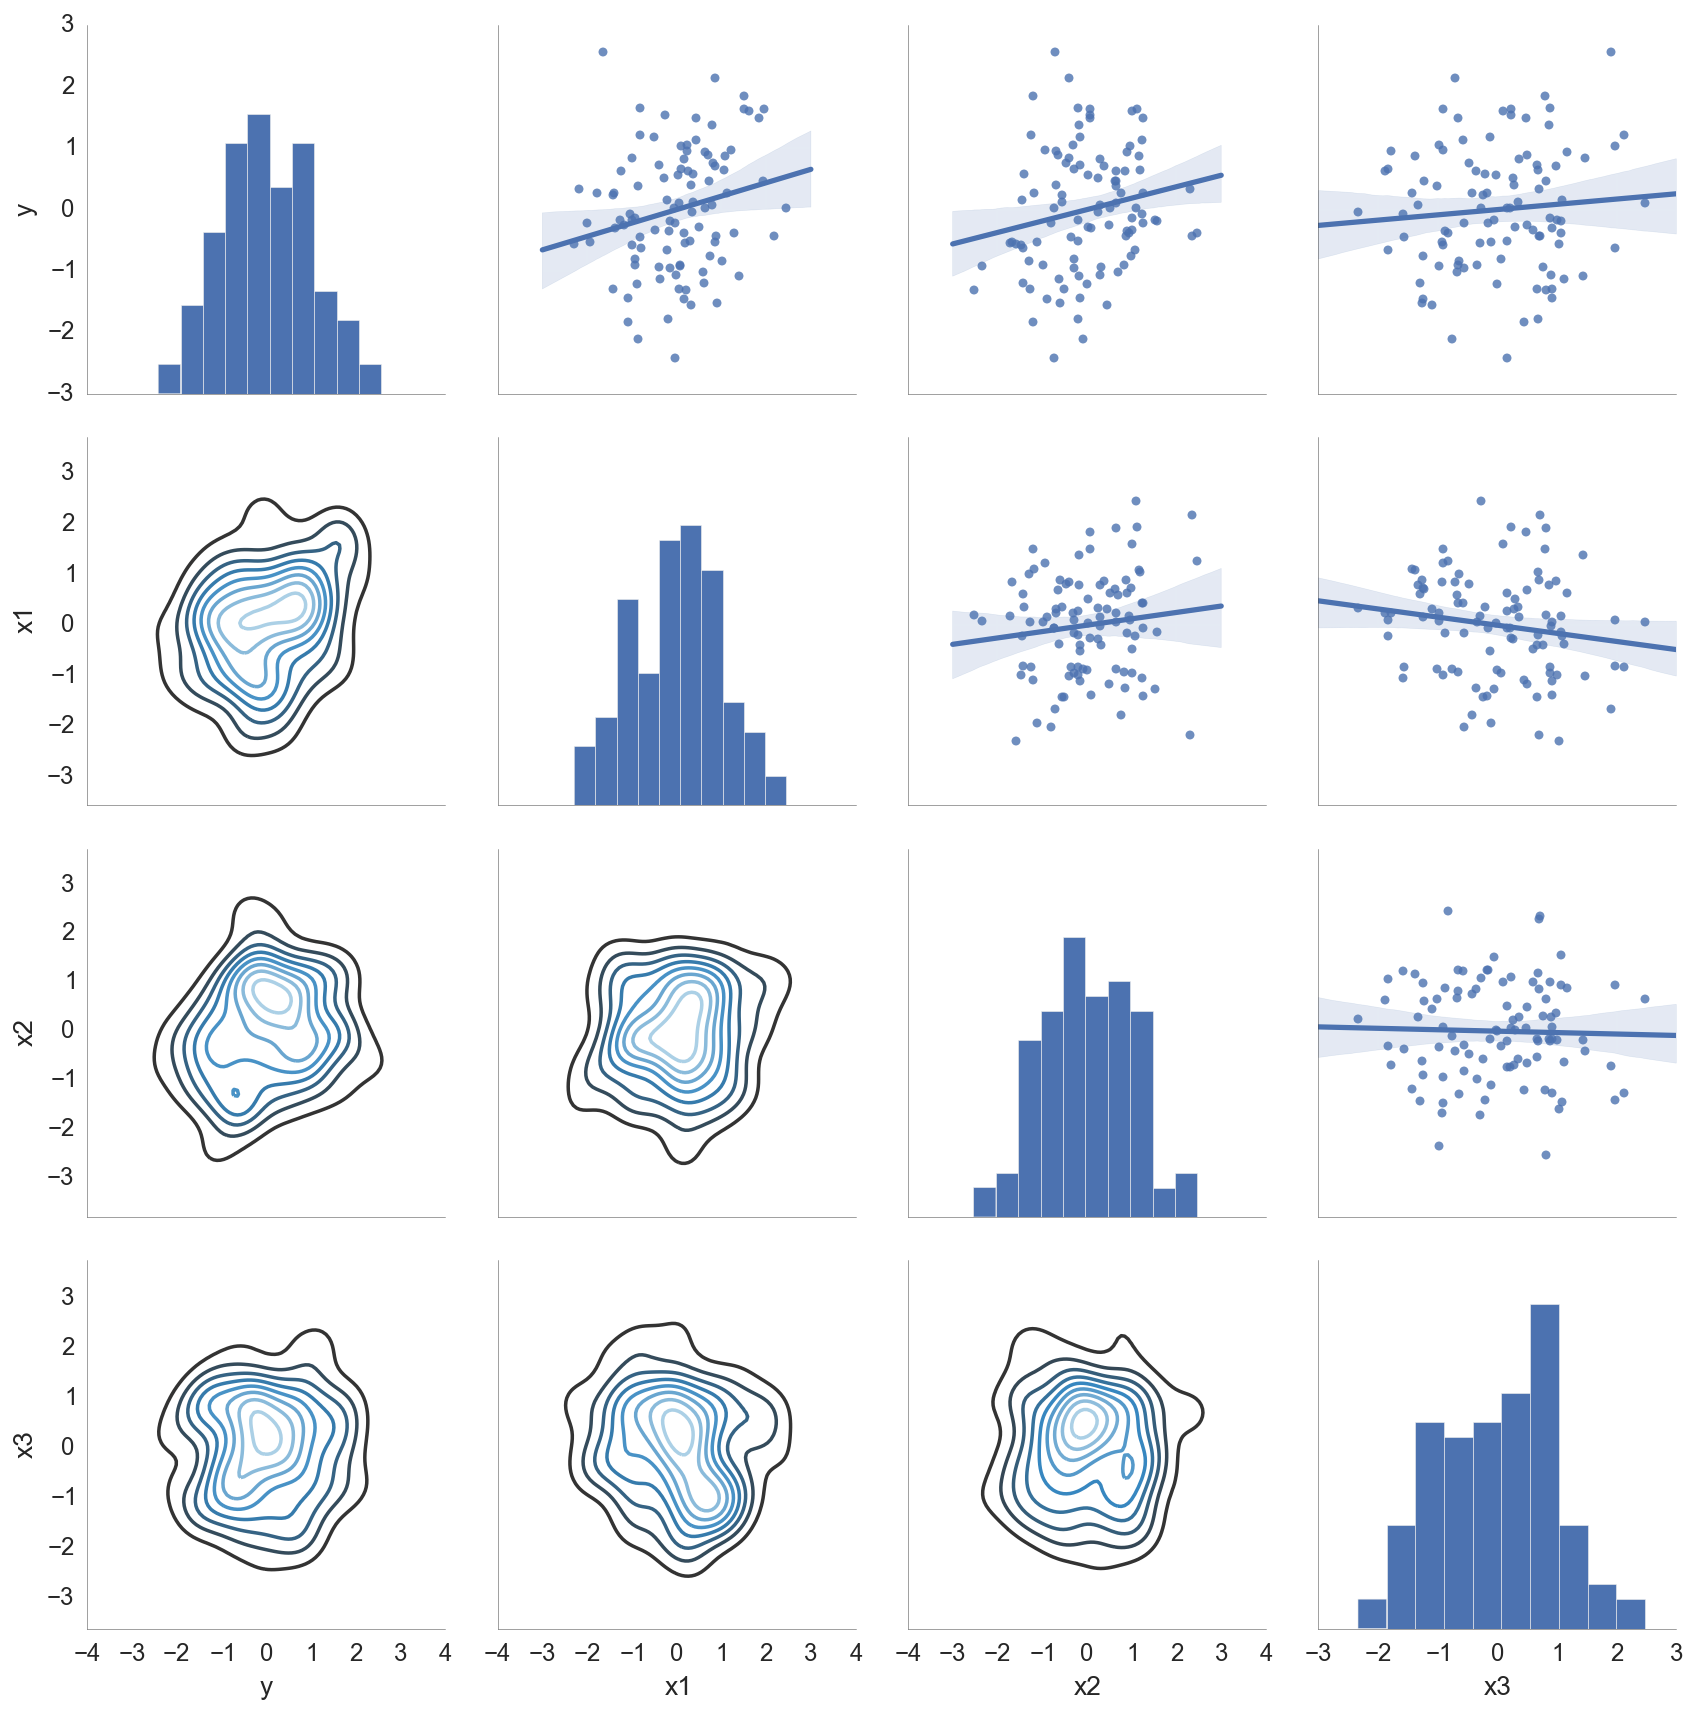

In [4]:
show_html("<h1>Data overview, all-vs-all</h1>")
g = sns.PairGrid(df)
#g.fig.suptitle('Data overview, all-vs-all', y=1.05, fontsize=28)
g.map_upper(sns.regplot)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(plt.hist)

Are the data normal?
===========
Regression performs better if the data are approximately normal.

It's not uncommon for some data types to be closer to log-normal than normal, i.e., the data look normal after taking the log.
For example, adult blood pressure is approximately [log-normal](http://en.wikipedia.org/wiki/Log-normal_distribution).
If that is the case, we will use the logged version.

/Users/briann/anaconda/lib/python2.7/site-packages/matplotlib/text.py:1857: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  warnings.warn("You have used the `textcoords` kwarg, but not "


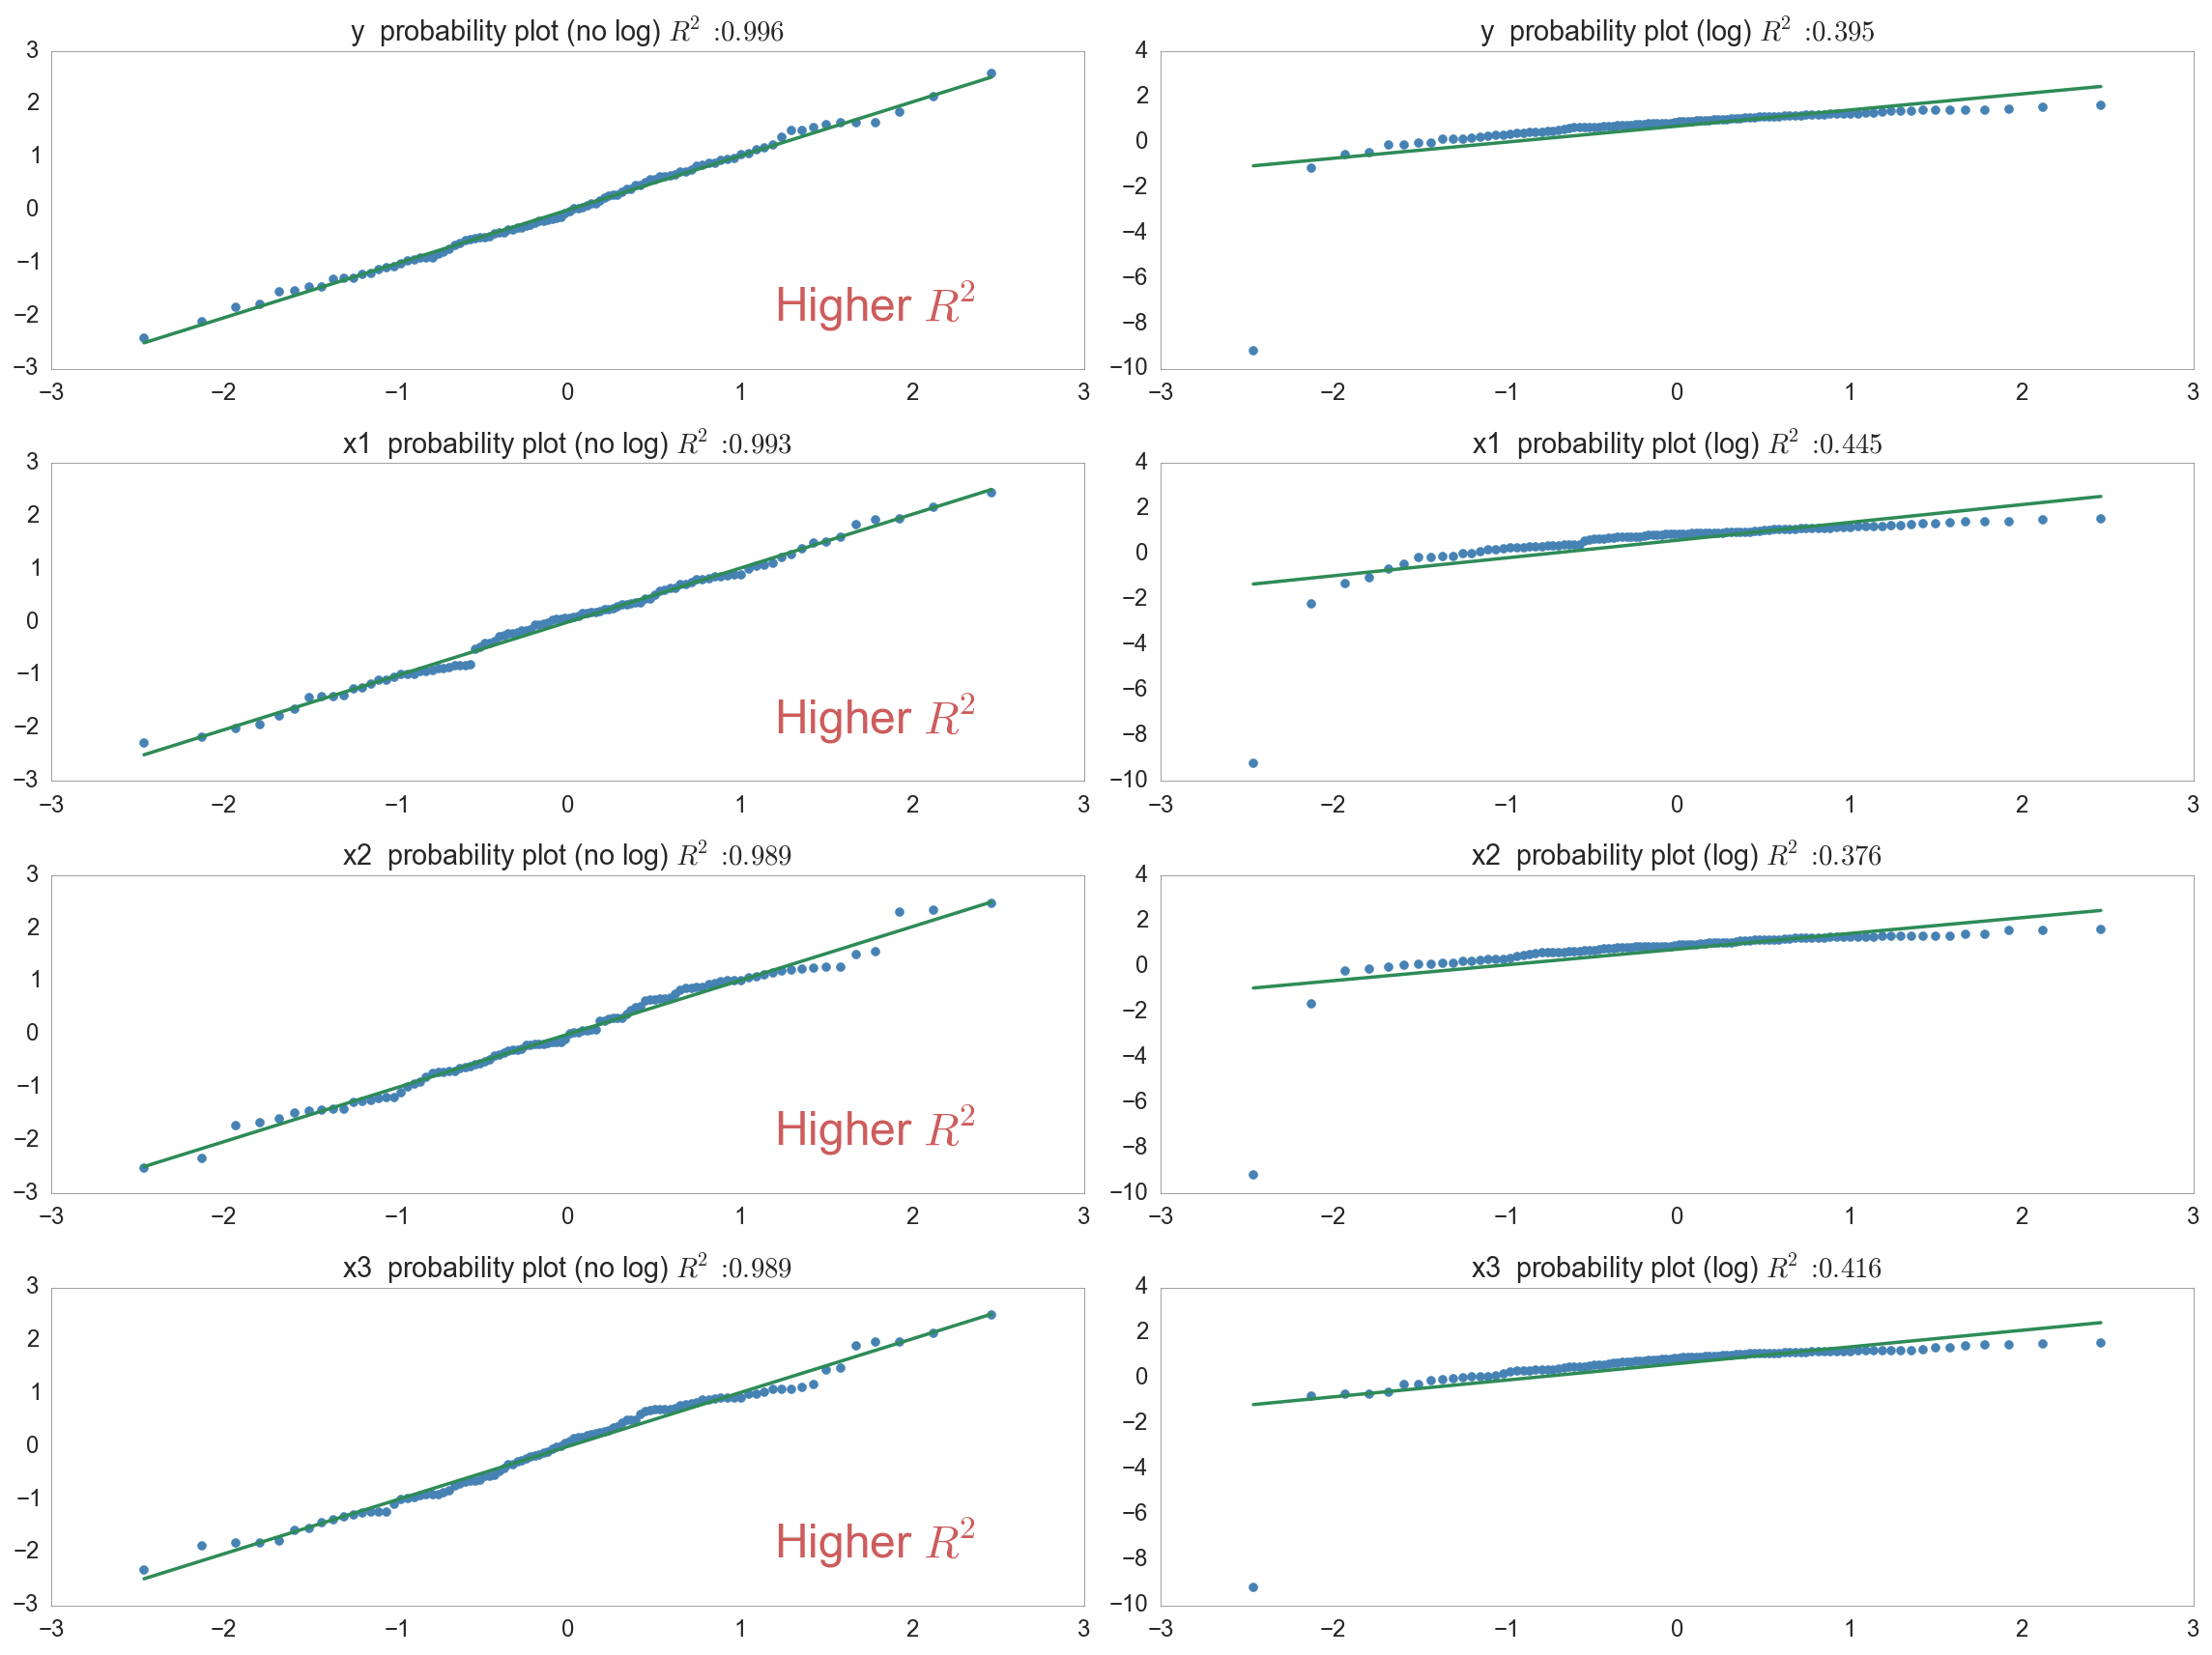

In [5]:
fig, ax = plt.subplots(figsize=(16,12))
#fig.suptitle('Compare fits for data vs logged data ', y=1.05, fontsize=28)
show_html("<h1>Compare fits for data vs logged data</h1>")
plt.subplots_adjust(hspace=1)
eps = 1e-4

for i, var in enumerate(df.columns):
    ax1 = plt.subplot(len(df.columns), 2, i*2+1)
    ax2 = plt.subplot(len(df.columns), 2, i*2+2)
    
    #
    # Original data (no log applied)
    #
    (_osm, _osr), (_slope, _intercept, _R) = probplot(df[var])
    ax1.scatter(_osm, _osr, color='steelblue')
    ax1.plot([_osm.min(), _osm.max()], [_intercept + _slope*_osm.min(), _intercept + _slope*_osm.max()], color='seagreen')
    ax1.set(title="{}  probability plot (no log) $R^2:{:.3f}$".format(var, _R**2))

    #
    # Data with log applied
    #
    log_X_var = np.log(eps - df[var].min() + df[var])
    (_osm, _osr), (_slope, _intercept, _Rlog) = probplot(log_X_var)

    ax2.scatter(_osm, _osr, color='steelblue')
    ax2.plot([_osm.min(), _osm.max()], [_intercept + _slope*_osm.min(), _intercept + _slope*_osm.max()], color='seagreen')
    ax2.set(title="{}  probability plot (log) $R^2:{:.3f}$".format(var, _Rlog**2))

    #
    # Decide whether to use original version or the logged version
    #
    if _Rlog > _R:
        _tmpfn1, _tmpval = df_fits[var], df[var].min() # necessary to avoid recursion problem
        df_fits[var] = lambda x: _tmpfn1(np.exp(x) + _tmpval - eps) # change inverse transform
        df[var] = np.log(eps - df[var].min() + df[var])
        annotate_ax = ax2
    else:
        annotate_ax = ax1

    annotate_ax.annotate("Higher $R^2$", xy=(0.7,0.15), textcoords='axes fraction', color='indianred', fontsize=24)
    
plt.tight_layout()

Linear Regression
==========
Apply [ordinary least-squares linear regression](http://en.wikipedia.org/wiki/Ordinary_least_squares).

A score of X is good.

In [6]:
X = df[df.columns[1:]].values
y = df[df.columns[0]].values

ols = LinearRegression(fit_intercept=True, normalize=False, n_jobs=-1)
ols.fit(X, y)

show_html('''
<h1>OLS linear regression results</h1>
<table>
<tr><td>Intercept</td><td>{intercept:.3f}</td></tr>
<tr><td>Coefficients</td><td>{coef:s}</td></tr>
<tr><td>Residual sum of squares</td><td>{rss:.3f}</td></tr>
<tr><td>$R^2$ of the prediction.</td><td>{score:.3f}</td></tr>
</table>'''.format(intercept = ols.intercept_,
            coef = ', '.join("{:s}:{:.3f}".format(df.columns[1:][i], ols.coef_[i]) for i in range(len(ols.coef_))), 
            rss = np.mean((ols.predict(X) - y) ** 2),
            score = ols.score(X, y))
)

Intercept,0.000
Coefficients,"x1:0.218, x2:0.163, x3:0.126"
Residual sum of squares,0.911
$R^2$ of the prediction.,0.089


Bayesian Regression Models (MCMC)
==============
Bayesian regression is more flexible than OLS. 
We can choose priors that best represent the data.
- [Ridge regression](http://en.wikipedia.org/wiki/Tikhonov_regularization)
- [Lasso](http://en.wikipedia.org/wiki/Least_squares#Lasso_method)


starting trace at MAP: {'x2': array(0.198376973449216), 'x3': array(0.16143339071490181), 'x1': array(3.5875903896395584e-09), 'tau': array(1.0565049625492926)}
 [-----------------100%-----------------] 200 of 200 complete in 0.5 sec

/Users/briann/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


starting trace at MAP: {'x2': array(0.21341491989839798), 'x3': array(0.18130062375987596), 'x1': array(-0.010650522835671281), 'tau': array(1.3725100112803654)}
 [-----------------100%-----------------] 200 of 200 complete in 0.5 sec

starting trace at MAP: {'x2': array(0.20724400703292245), 'x3': array(0.173618006223192), 'x1': array(-0.0010335942764926889), 'tau': array(1.37173292764498)}
 [-----------------100%-----------------] 200 of 200 complete in 0.5 sec

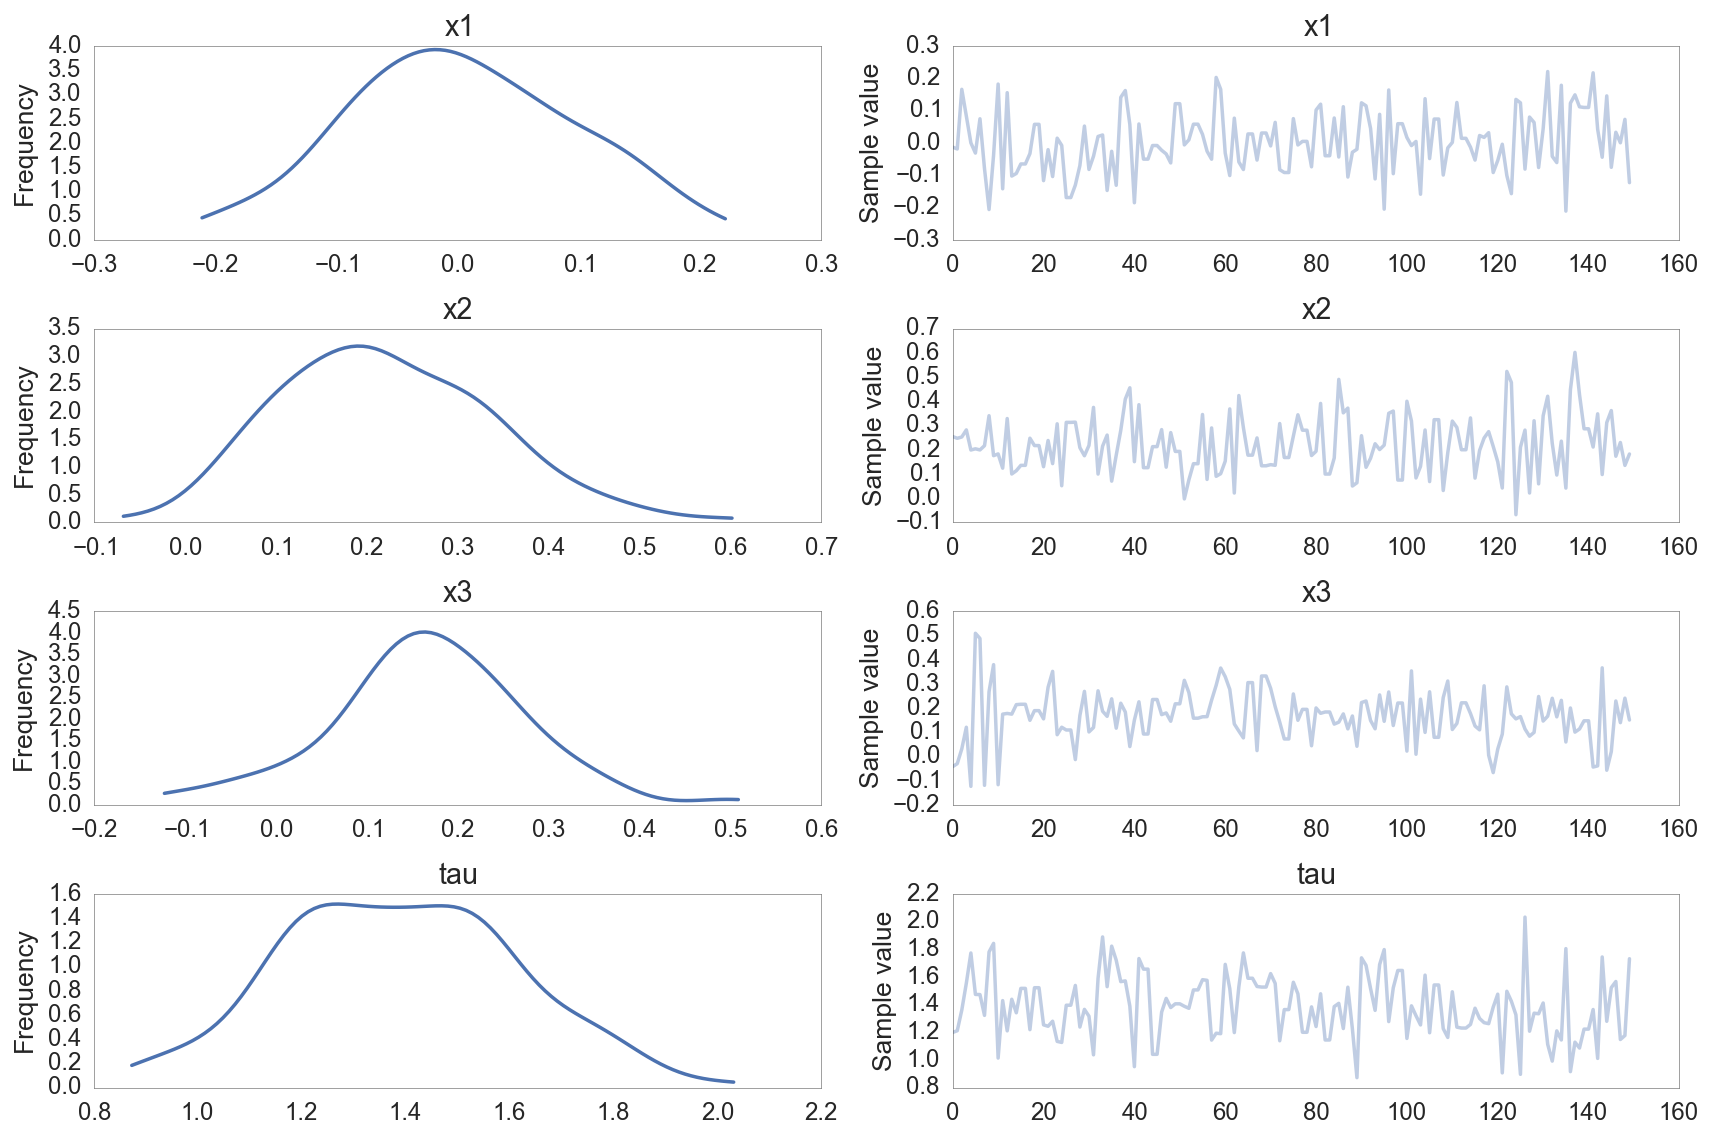

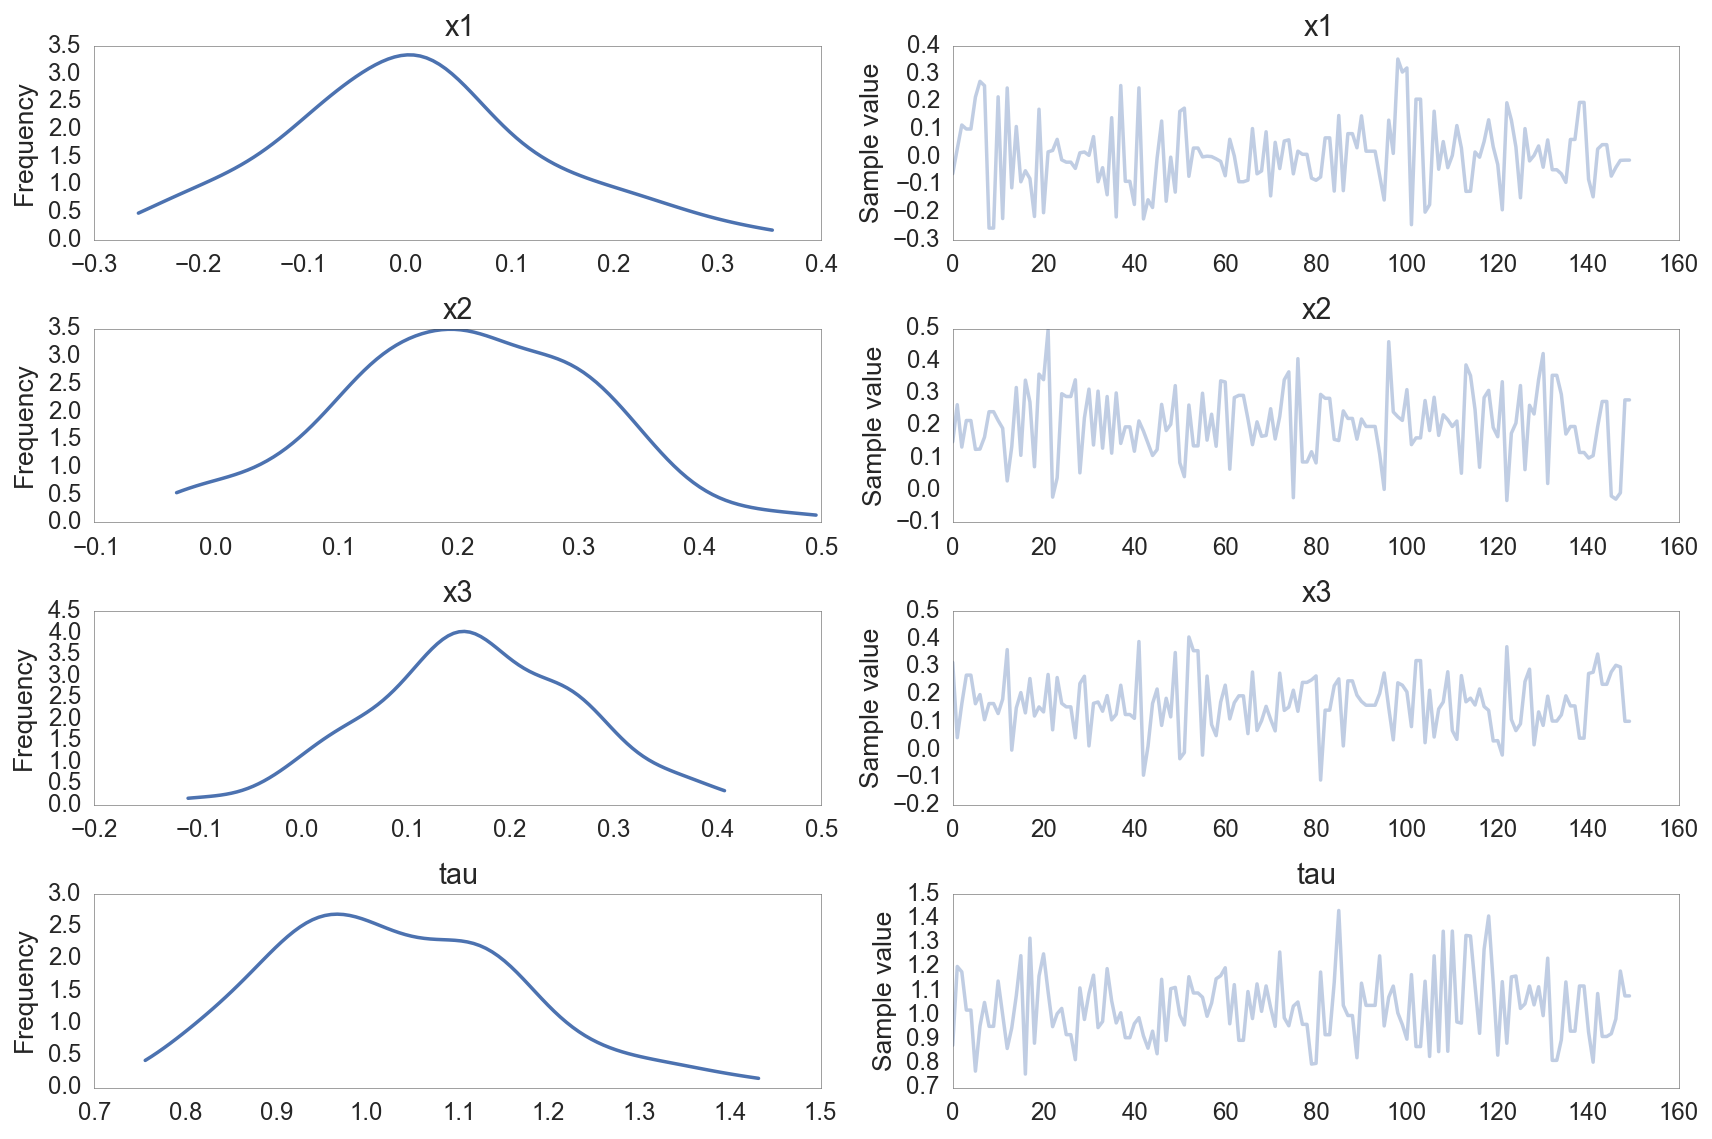

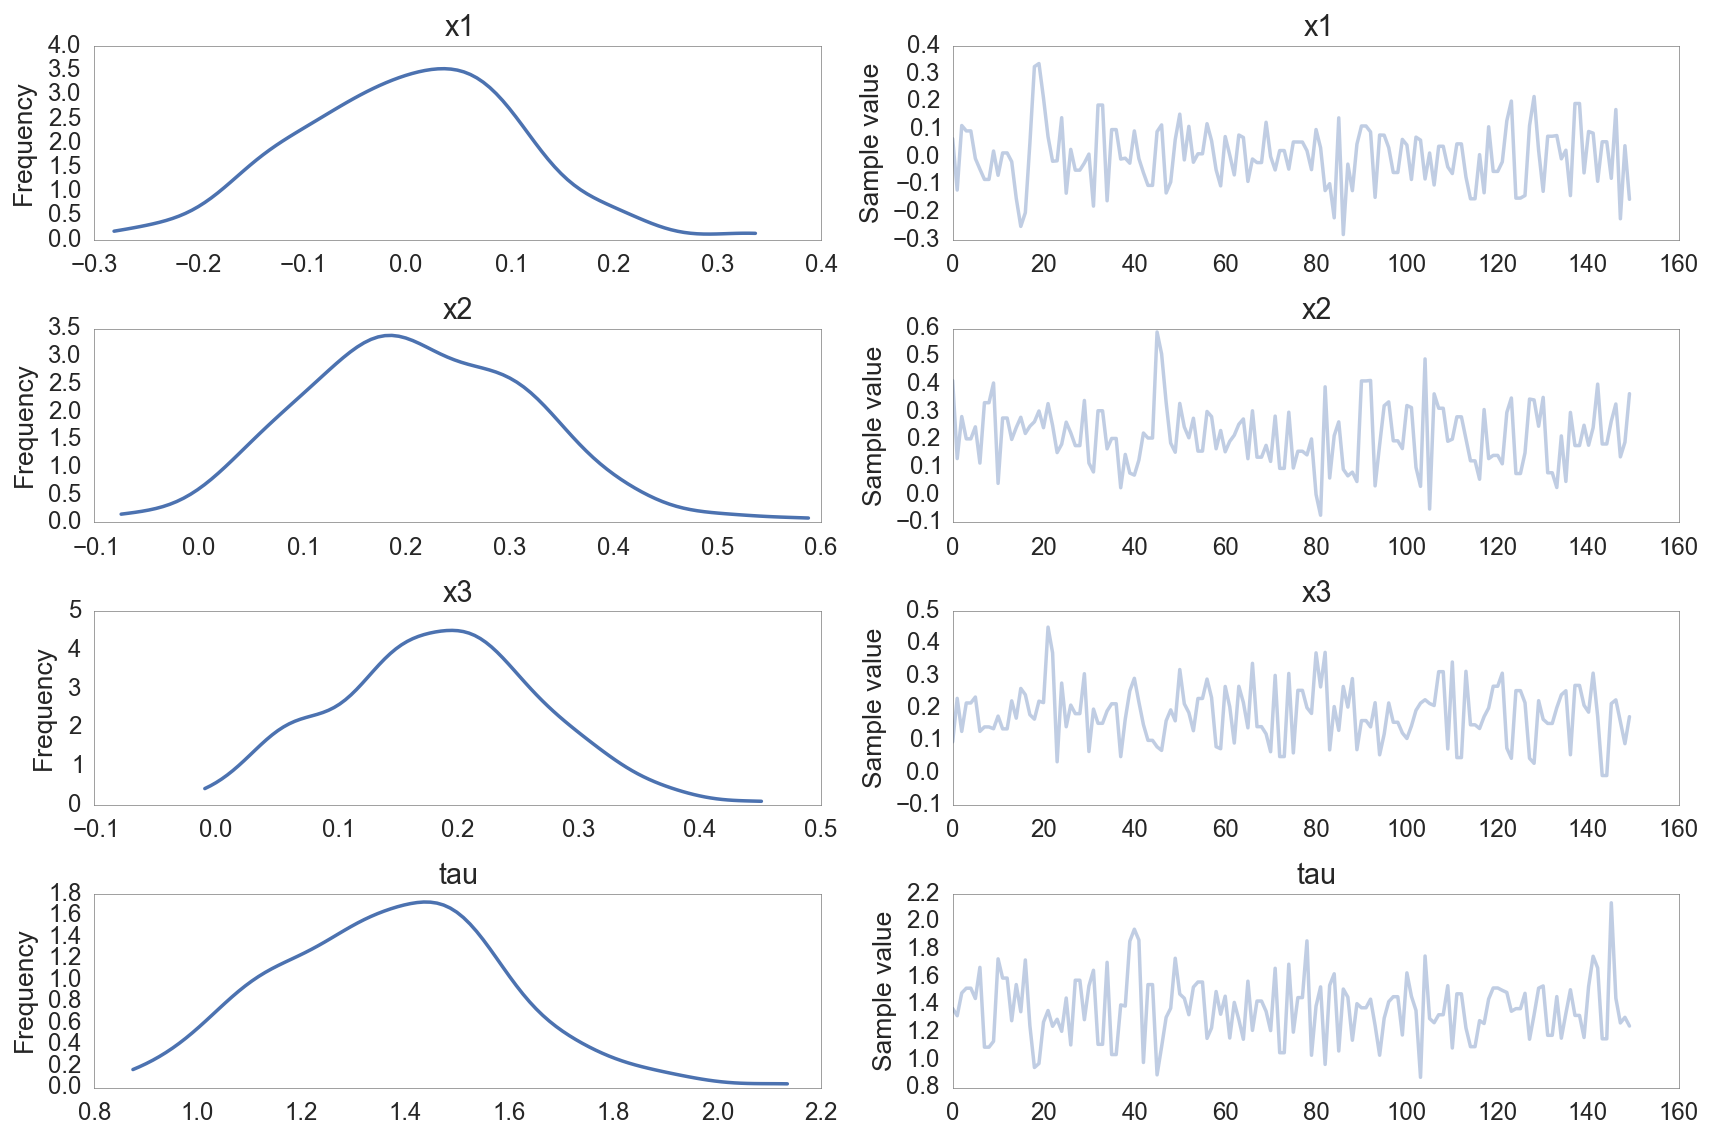

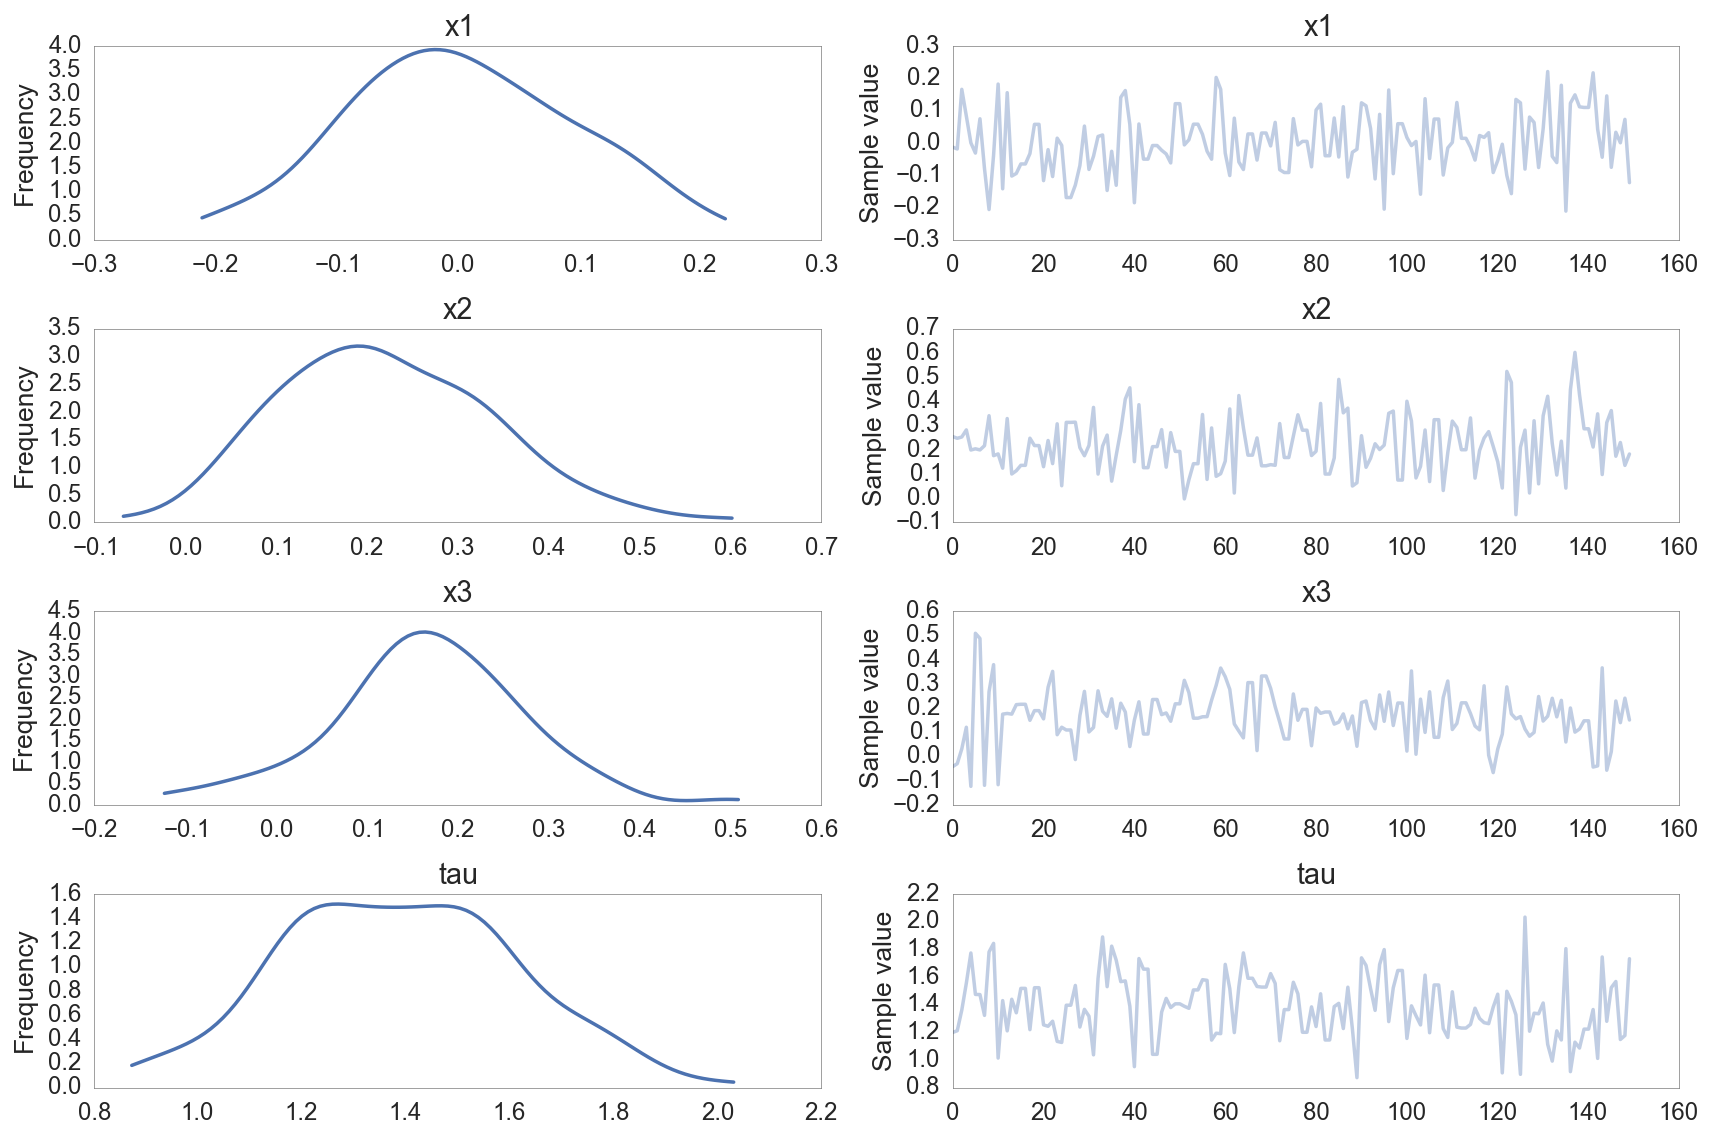

In [7]:
burnin, num_samples = 50, 200
np.random.seed(1)

# Add a column for the intercept (x_0)
X_1 = np.column_stack( (np.ones(X.shape[0]),  X) )
beta_names = list(df.columns[1:]) #['beta_{}'.format(i) for i in range(X_1.shape[1])]

def regress(regression="ridge", error="normal", beta_names=beta_names, nu=5):
    with pm.Model() as model:
        #
        # Priors
        #
        if regression == "ols":
            betas = [pm.Uniform(beta, -10, 10) for beta in beta_names] # >10 is really slow...
        elif regression == "ridge":
            betas = [pm.Normal(beta, mu=0, tau=1.0) for beta in beta_names]
        elif regression == "lasso":
            betas = [pm.Laplace(beta, mu=0, b=1.0) for beta in beta_names]
        else:
            raise ValueError, "No regression of type {}".format(regression)
        
        # prior on Normal/T error variance. Gamma(1,1) has mean=1, variance=1
        tau = pm.Gamma('tau', 1, 1)
        
        #
        # Likelihood
        #
        # mu ~ beta0 + beta1 * x1 + beta2 * x2 + beta3 * x3
        mu = sum(betas[n]*X_1[:,n] for n in range(len(betas)))
        
        if error == "normal":
            y_obs = pm.Normal('y_obs', mu=mu, tau=tau, observed=y)
        elif error == "T":
            y_obs = pm.T('y_obs', nu=nu, mu=mu, lam=tau, observed=y)
        else:
            raise ValueError, "No error model of type {}".format(error)
        
        #
        # Sample
        #
        start = pm.find_MAP()
        print("starting trace at MAP:", start)
        for k in start:
            if start[k] == 0: start[k] += .01 # avoids some corner cases?
        step = pm.NUTS(state=start, scaling=start)
        trace = pm.sample(num_samples, step, start, progressbar=True, njobs=1)[burnin:]
        #pm.traceplot(trace)
    return trace

trace = {}
show_html("<h1>Ordinary Least Squares</h1>")
trace['ols'] = regress(regression="ols", error="normal")
pm.traceplot(trace['ols'])
show_html("<h1>Ridge Regression</h1>")
trace['ridge/T'] = regress(regression="ridge", error="T")
pm.traceplot(trace['ridge/T'])
show_html("<h1>LASSO</h1>")
trace['lasso/T'] = regress(regression="lasso", error="T")
pm.traceplot(trace['lasso/T'])


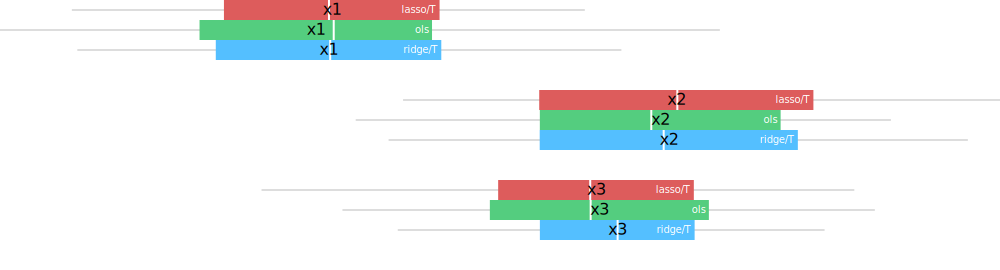

In [10]:
#--------------------------------------------
# Compare models
#
stats, quartiles = {}, {}
for regression in trace:
    stats[regression], quartiles[regression] = {}, {}
    
    for var in trace[regression].varnames:
        post_quar = pm.stats._calculate_posterior_quantiles(trace[regression][var], qlist=[5,25,50,75,95])
        _key, quartiles[regression][var] = post_quar.next(), post_quar.next()

        post_stats = pm.stats._calculate_stats(trace[regression][var], batches=100, alpha=0.05)
        _key, stats[regression][var] = post_stats.next(), post_stats.next()

# Graph all models
min_beta = min(min(quartiles[regression][var].values()) for regression in trace for var in beta_names)
max_beta = max(max(quartiles[regression][var].values()) for regression in trace for var in beta_names)

rh = 20
rh2 = 20*1.5*len(beta_names)
svgw = 1000
svgh = rh2 * len(beta_names)
def _norm(val): return svgw * (val - min_beta) / (max_beta - min_beta)
def _normw(val): return svgw * val / (max_beta - min_beta)

ssvg = ''
colors = ["#DD5C5C ", "#54CD7F", "#54BFFF", "#44dd99"]
for i, beta in enumerate(beta_names):
    for j, regression in enumerate(trace):
        color = colors[j%len(colors)]
        
        s, q = stats[regression][beta], quartiles[regression][beta]
        x = q['q25']
        w = q['q75'] - q['q25']
        m, lo, hi = s['mean'], q['lo'], q['hi']
        y = rh2*i + rh*j
        
        ssvg += '<line x1="{x1:f}" y1="{y1:f}" x2="{x2:f}" y2="{y2:f}" stroke="#777777" stroke-width=".5"/>'.format(
            x1=_norm(lo), y1=y+rh/2, x2=_norm(hi), y2=y+rh/2)
        ssvg += '<rect x="{x:f}" y="{y:f}" width="{w:f}" height="{h:f}" fill="{color:s}" />'.format(
            x=_norm(x), w=_normw(w), y=y, h=rh, color=color)
        ssvg += '<rect x="{x:f}" y="{y:f}" width="2px" height="{h:f}" fill="#ffffff" />'.format(
            x=_norm(m), w=2, y=y, h=rh)
        ssvg += '<text x="{x:f}" y="{y:f}" text-anchor="middle" dy="0.3em">{text}</text>'.format(
            x=_norm(x + w/2), y=y+rh/2, text=beta)
        ssvg += '<text x="{x:f}" y="{y:f}" text-anchor="end" dy="0.3em" fill="#ffffff" font-size="10">{text}</text>'.format(
            x=_norm(x + w) - 3, y=y+rh/2, text=regression)

show_html("<h1>Analysis of the difference between different regressions</h1>")
show_svg(ssvg, w=svgw, h=svgh)